In [1]:
!pip install xgboost


In [2]:
!pip install feature-engine




In [2]:
import os





import warnings

import numpy as np

import pandas as pd

from xgboost import XGBRegressor

import sklearn
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
	OneHotEncoder,
	OrdinalEncoder,
	StandardScaler,
	MinMaxScaler,
	PowerTransformer,
	FunctionTransformer
)
from feature_engine.outliers import Winsorizer
from feature_engine.datetime import DatetimeFeatures
from feature_engine.selection import SelectBySingleFeaturePerformance
from feature_engine.encoding import (
	RareLabelEncoder,
	MeanEncoder,
	CountFrequencyEncoder
)
import joblib
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

## Display Settings

In [3]:
pd.set_option("display.max_columns", None)

In [10]:
sklearn.set_config(transform_output="pandas")

In [5]:
warnings.filterwarnings("ignore")

## Getting Data

In [6]:
path_r=r"C:\Users\Paulastha Maitra\Desktop\flight\data\train.csv"
path_v=r"C:\Users\Paulastha Maitra\Desktop\flight\data\val.csv"
path_t=r"C:\Users\Paulastha Maitra\Desktop\flight\data\test.csv"
train = pd.read_csv(path_r)
val = pd.read_csv(path_v)
test = pd.read_csv(path_t)

In [7]:
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-03-21,Banglore,New Delhi,08:55:00,19:10:00,615,1.0,In-flight meal not included,7832
1,Jet Airways,2019-03-27,Delhi,Cochin,17:30:00,04:25:00,655,1.0,In-flight meal not included,6540
2,Goair,2019-03-09,Banglore,New Delhi,11:40:00,14:35:00,175,0.0,No Info,7305
3,Air India,2019-06-12,Kolkata,Banglore,09:25:00,18:30:00,545,1.0,No Info,8366
4,Jet Airways,2019-03-12,Banglore,New Delhi,22:55:00,07:40:00,525,1.0,In-flight meal not included,11087
...,...,...,...,...,...,...,...,...,...,...
6690,Jet Airways,2019-03-21,Delhi,Cochin,10:45:00,18:50:00,1925,2.0,No Info,11093
6691,Air India,2019-05-01,Kolkata,Banglore,09:25:00,18:30:00,545,1.0,No Info,8891
6692,Jet Airways,2019-06-01,Delhi,Cochin,14:00:00,19:00:00,300,1.0,In-flight meal not included,10262
6693,Air Asia,2019-06-24,Delhi,Cochin,07:55:00,13:25:00,330,1.0,No Info,6152


## Preprocessing Operations

In [8]:
# airline
air_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("grouper", RareLabelEncoder(tol=0.1, replace_with="Other", n_categories=2)),
    ("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
])

#doj
feature_to_extract = ["month", "week", "day_of_week", "day_of_year"]

doj_transformer = Pipeline(steps=[
    ("dt", DatetimeFeatures(features_to_extract=feature_to_extract, yearfirst=True, format="mixed")),
    ("scaler", MinMaxScaler())
])

# source & destination
location_pipe1 = Pipeline(steps=[
    ("grouper", RareLabelEncoder(tol=0.1, replace_with="Other", n_categories=2)),
    ("encoder", MeanEncoder(unseen="ignore",missing_values='ignore')),
    ("scaler", PowerTransformer())
])
def is_north(X):
    columns = X.columns.to_list()
    north_cities = ["Delhi", "Kolkata", "Mumbai", "New Delhi"]
    return (
        X
        .assign(**{
            f"{col}_is_north": X.loc[:, col].isin(north_cities).astype(int)
            for col in columns
        })
        .drop(columns=columns)
    )

location_transformer = FeatureUnion(transformer_list=[
    ("part1", location_pipe1),
    ("part2", FunctionTransformer(func=is_north))
])

# dep_time & arrival_time
time_pipe1 = Pipeline(steps=[
    ("dt", DatetimeFeatures(features_to_extract=["hour", "minute"])),
    ("scaler", MinMaxScaler())
])
def part_of_day(X, morning=4, noon=12, eve=16, night=20):
    columns = X.columns.to_list()
    X_temp = X.assign(**{
        col: pd.to_datetime(X.loc[:, col]).dt.hour
        for col in columns
    })

    return (
        X_temp
        .assign(**{
            f"{col}_part_of_day": np.select(
                [X_temp.loc[:, col].between(morning, noon, inclusive="left"),
                 X_temp.loc[:, col].between(noon, eve, inclusive="left"),
                 X_temp.loc[:, col].between(eve, night, inclusive="left")],
                ["morning", "afternoon", "evening"],
                default="night"
            )
            for col in columns
        })
        .drop(columns=columns)
    )

time_pipe2 = Pipeline(steps=[
    ("part", FunctionTransformer(func=part_of_day)),
    ("encoder", CountFrequencyEncoder()),
    ("scaler", MinMaxScaler())
])

time_transformer = FeatureUnion(transformer_list=[
    ("part1", time_pipe1),
    ("part2", time_pipe2)
])
# duration
class RBFPercentileSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, variables=None, percentiles=[0.25, 0.5, 0.75], gamma=0.1):
        self.variables = variables
        self.percentiles = percentiles
        self.gamma = gamma


    def fit(self, X, y=None):
        if not self.variables:
            self.variables = X.select_dtypes(include="number").columns.to_list()

        self.reference_values_ = {
            col: (
                X
                .loc[:, col]
                .quantile(self.percentiles)
                .values
                .reshape(-1, 1)
            )
            for col in self.variables
        }

        return self


    def transform(self, X):
        objects = []
        for col in self.variables:
            columns = [f"{col}_rbf_{int(percentile * 100)}" for percentile in self.percentiles]
            obj = pd.DataFrame(
                data=rbf_kernel(X.loc[:, [col]], Y=self.reference_values_[col], gamma=self.gamma),
                columns=columns
            )
            objects.append(obj)
        return pd.concat(objects, axis=1)
def duration_category(X, short=180, med=400):
    return (
        X
        .assign(duration_cat=np.select([X.duration.lt(short),
                                    X.duration.between(short, med, inclusive="left")],
                                    ["short", "medium"],
                                    default="long"))
        .drop(columns="duration")
    )

def is_over(X, value=1000):
    return (
        X
        .assign(**{
            f"duration_over_{value}": X.duration.ge(value).astype(int)
        })
        .drop(columns="duration")
    )

duration_pipe1 = Pipeline(steps=[
    ("rbf", RBFPercentileSimilarity()),
    ("scaler", PowerTransformer())
])

duration_pipe2 = Pipeline(steps=[
    ("cat", FunctionTransformer(func=duration_category)),
    ("encoder", OrdinalEncoder(categories=[["short", "medium", "long"]]))
])

duration_union = FeatureUnion(transformer_list=[
    ("part1", duration_pipe1),
    ("part2", duration_pipe2),
    ("part3", FunctionTransformer(func=is_over)),
    ("part4", StandardScaler())
])
duration_transformer = Pipeline(steps=[
    ("outliers", Winsorizer(capping_method="iqr", fold=1.5)),
    ("imputer", SimpleImputer(strategy="median")),
    ("union", duration_union)
])

# total_stops
def is_direct(X):
    return X.assign(is_direct_flight=X.total_stops.eq(0).astype(int))


total_stops_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("", FunctionTransformer(func=is_direct))
])

# additional_info
info_pipe1 = Pipeline(steps=[
    ("group", RareLabelEncoder(tol=0.1, n_categories=2, replace_with="Other")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

def have_info(X):
    return X.assign(additional_info=X.additional_info.ne("No Info").astype(int))

info_union = FeatureUnion(transformer_list=[
("part1", info_pipe1),
("part2", FunctionTransformer(func=have_info))
])

info_transformer = Pipeline(steps=[
("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
("union", info_union)
])
# column transformer
column_transformer = ColumnTransformer(transformers=[
("air", air_transformer, ["airline"]),
("doj", doj_transformer, ["date_of_journey"]),
("location", location_transformer, ["source", 'destination']),
("time", time_transformer, ["dep_time", "arrival_time"]),
("dur", duration_transformer, ["duration"]),
("stops", total_stops_transformer, ["total_stops"]),
("info", info_transformer, ["additional_info"])
], remainder="passthrough")

# feature selector
estimator = RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)

selector = SelectBySingleFeaturePerformance(
estimator=estimator,
scoring="r2",
threshold=0.1
) 

# preprocessor
preprocessor = Pipeline(steps=[
("ct", column_transformer),
("selector", selector)
])


In [11]:
preprocessor.fit(
    train.drop(columns="price"),
    train.price.copy()
)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('air',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('grouper',
                                                                   RareLabelEncoder(n_categories=2,
                                                                                    replace_with='Other',
                                                                                    tol=0.1)),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline']),
                                                 ('doj',
                                                  Pipeline(steps=[('dt',
                                                                   Datetime...
                                                                                                                                     replace_with='Other',
                                                                                                                                     tol=0.1)),
                                                                                                                   ('encoder',
                                                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                                                  sparse_output=False))])),
                                                                                                  ('part2',
                                                                                                   FunctionTransformer(func=<function have_info at 0x000001A403CF28E0>))]))]),
                                                  ['additional_info'])])),
                ('selector',
                 SelectBySingleFeaturePerformance(estimator=RandomForestRegressor(max_depth=3,
                                                                                  n_estimators=10,
                                                                                  random_state=42),
                                                  scoring='r2',
                                                  threshold=0.1))])

## Model Selection


In [12]:
algorithms = {
	"Linear Regression": LinearRegression(),
	"Support Vector Machine": SVR(),
	"Random Forest": RandomForestRegressor(n_estimators=10),
	"XG Boost": XGBRegressor(n_estimators=10)
}

In [13]:
def split_data(data):
	X = data.drop(columns="price")
	y = data.price.copy()
	return (X, y)

In [47]:
data = pd.concat([train, val], axis=0)

X_data, y_data = split_data(data)
print(X_data.shape, y_data.shape)

(8369, 9) (8369,)


In [48]:
def plot_curves(sizes, mean_scores, std_scores, label, ax):
	ax.plot(
		sizes,
		mean_scores,
		marker="o",
		label=label
	)

	ax.fill_between(
		x=sizes,
		y1=mean_scores - std_scores,
		y2=mean_scores + std_scores,
		alpha=0.5
	)

In [49]:
def plot_learning_curves(name, algorithm, figsize=(12, 4)):
	model = Pipeline(steps=[
		("pre", preprocessor),
		("alg", algorithm)
	])

	train_sizes, train_scores, test_scores = learning_curve(
		estimator=model,
		X=X_data,
		y=y_data,
		cv=3,
		scoring="r2",
		n_jobs=-1,
		random_state=42
	)
	
	mean_train_scores = np.mean(train_scores, axis=1)
	std_train_scores = np.std(train_scores, axis=1)
	train_score = f"{mean_train_scores[-1]:.2f} +/- {std_train_scores[-1]:.2f}"

	mean_test_scores = np.mean(test_scores, axis=1)
	std_test_scores = np.std(test_scores, axis=1)
	test_score = f"{mean_test_scores[-1]:.2f} +/- {std_test_scores[-1]:.2f}"

	fig, ax = plt.subplots(figsize=figsize)

	# training curve
	plot_curves(
		train_sizes,
		mean_train_scores,
		std_train_scores,
		f"Train ({train_score})",
		ax
	)

	# test curve
	plot_curves(
		train_sizes,
		mean_test_scores,
		std_test_scores,
		f"Test ({test_score})",
		ax
	)

	ax.set(xlabel="Training Set Size", ylabel="R-square", title=name)

	ax.legend(loc="lower right")

	plt.show()

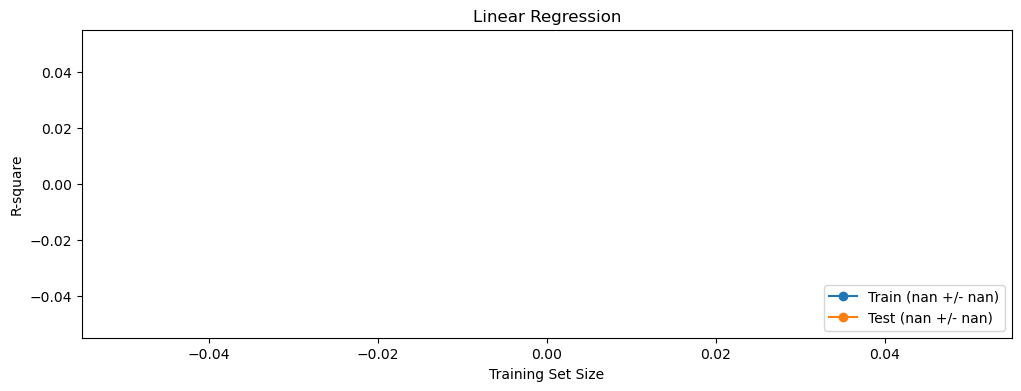

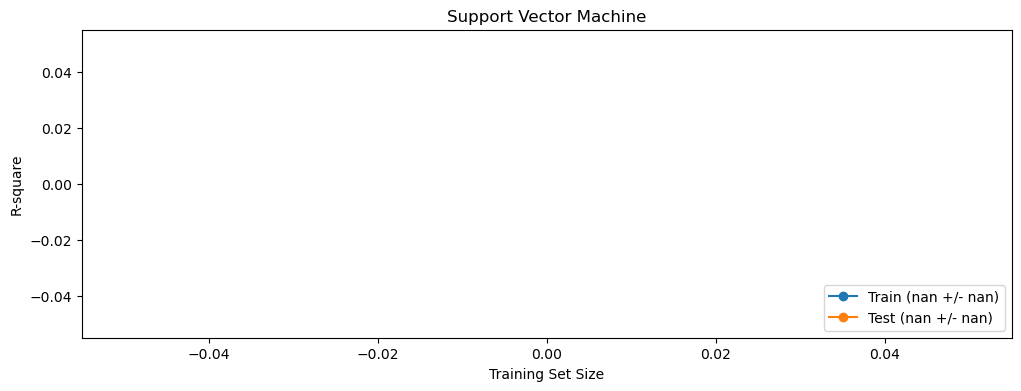

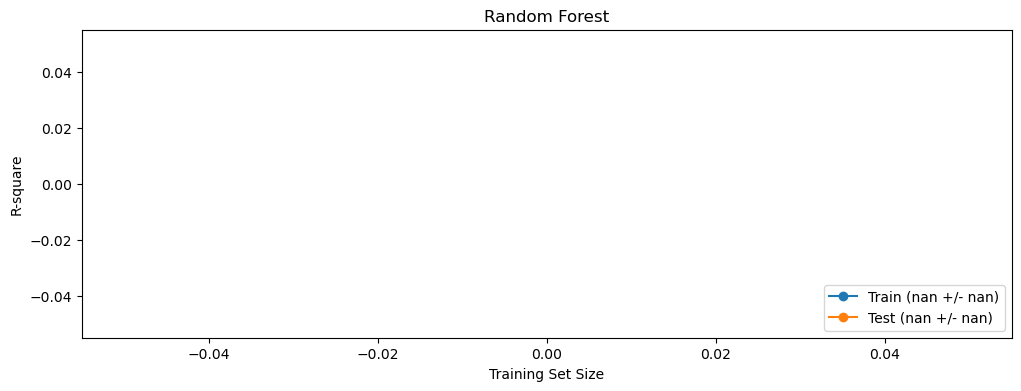

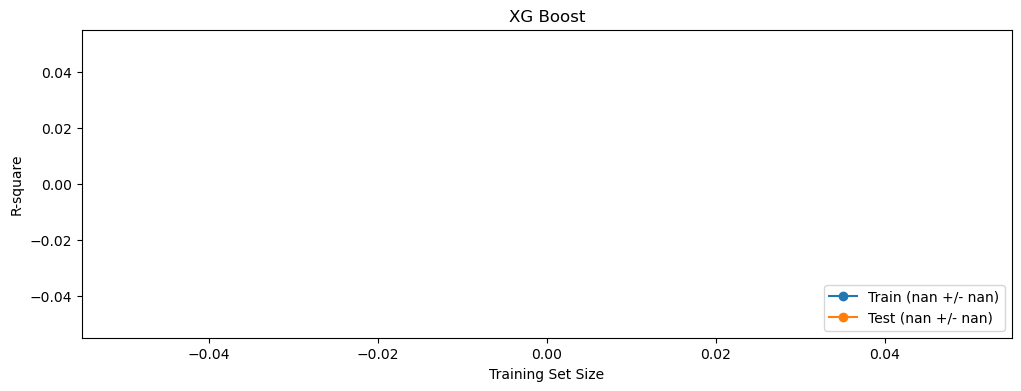

In [51]:
for name, alg in algorithms.items():
	plot_learning_curves(name, alg)

In [14]:
X_test, y_test = split_data(test)
print(X_test.shape, y_test.shape)

(2093, 9) (2093,)


In [15]:
X_train, y_train = split_data(train)
print(X_train.shape, y_train.shape)

(6695, 9) (6695,)


# For Random Forest

In [91]:
model = Pipeline(steps=[
	("pre", preprocessor),
	("rf", RandomForestRegressor(n_estimators=10))
])

In [92]:
model.fit(X_train, y_train)

Pipeline(steps=[('pre',
                 Pipeline(steps=[('ct',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('air',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('grouper',
                                                                                    RareLabelEncoder(n_categories=2,
                                                                                                     replace_with='Other',
                                                                                                     tol=0.1)),
                                                                                   ('encoder',
                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                  sparse_output=False))]),
                                                                   ['airline']),
                                                                  ('doj',
                                                                   Pipelin...
                                                                                                                                     OneHotEncoder(handle_unknown='ignore',
                                                                                                                                                   sparse_output=False))])),
                                                                                                                   ('part2',
                                                                                                                    FunctionTransformer(func=<function have_info at 0x000001A403CF28E0>))]))]),
                                                                   ['additional_info'])])),
                                 ('selector',
                                  SelectBySingleFeaturePerformance(estimator=RandomForestRegressor(max_depth=3,
                                                                                                   n_estimators=10,
                                                                                                   random_state=42),
                                                                   scoring='r2',
                                                                   threshold=0.1))])),
                ('rf', RandomForestRegressor(n_estimators=10))])

In [93]:
def evaluate_model(X, y):
	y_pred = model.predict(X)
	return r2_score(y, y_pred)

In [94]:
print(f"R2 score on Training data is = {evaluate_model(X_train, y_train)}")

R2 score on Training data is = 0.9226878225663914


In [95]:
print(f"R2 score on Test data is = {evaluate_model(X_test, y_test)}")

R2 score on Test data is = 0.6777809051851111


## For Linear Regression

In [22]:
model = Pipeline(steps=[
	("pre", preprocessor),
	("lr", LinearRegression())
])

In [24]:
model.fit(X_train, y_train)

Pipeline(steps=[('pre',
                 Pipeline(steps=[('ct',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('air',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('grouper',
                                                                                    RareLabelEncoder(n_categories=2,
                                                                                                     replace_with='Other',
                                                                                                     tol=0.1)),
                                                                                   ('encoder',
                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                  sparse_output=False))]),
                                                                   ['airline']),
                                                                  ('doj',
                                                                   Pipelin...
                                                                                                                                    ('encoder',
                                                                                                                                     OneHotEncoder(handle_unknown='ignore',
                                                                                                                                                   sparse_output=False))])),
                                                                                                                   ('part2',
                                                                                                                    FunctionTransformer(func=<function have_info at 0x000001A403CF28E0>))]))]),
                                                                   ['additional_info'])])),
                                 ('selector',
                                  SelectBySingleFeaturePerformance(estimator=RandomForestRegressor(max_depth=3,
                                                                                                   n_estimators=10,
                                                                                                   random_state=42),
                                                                   scoring='r2',
                                                                   threshold=0.1))])),
                ('lr', LinearRegression())])

In [25]:
print(f"R2 score on Training data is = {evaluate_model(X_train, y_train)}")

R2 score on Training data is = 0.5501239429295681


In [26]:
print(f"R2 score on Test data is = {evaluate_model(X_test, y_test)}")

R2 score on Test data is = 0.5290920453454981


## For XgBoost

In [36]:
model = Pipeline(steps=[
	("pre", preprocessor),
	("xg", XGBRegressor(n_estimators=10))
])

In [37]:
model.fit(X_train, y_train)

Pipeline(steps=[('pre',
                 Pipeline(steps=[('ct',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('air',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('grouper',
                                                                                    RareLabelEncoder(n_categories=2,
                                                                                                     replace_with='Other',
                                                                                                     tol=0.1)),
                                                                                   ('encoder',
                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                  sparse_output=False))]),
                                                                   ['airline']),
                                                                  ('doj',
                                                                   Pipelin...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=10, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [38]:
print(f"R2 score on Training data is = {evaluate_model(X_train, y_train)}")

R2 score on Training data is = 0.8143647313117981


In [29]:
print(f"R2 score on Test data is = {evaluate_model(X_test, y_test)}")

R2 score on Test data is = 0.7446268200874329


## For SVR

In [41]:
model = Pipeline(steps=[
	("pre", preprocessor),
	("xg", SVR(kernel="rbf"))
])

In [42]:
model.fit(X_train, y_train)

Pipeline(steps=[('pre',
                 Pipeline(steps=[('ct',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('air',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('grouper',
                                                                                    RareLabelEncoder(n_categories=2,
                                                                                                     replace_with='Other',
                                                                                                     tol=0.1)),
                                                                                   ('encoder',
                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                  sparse_output=False))]),
                                                                   ['airline']),
                                                                  ('doj',
                                                                   Pipelin...
                                                                                                                                                      tol=0.1)),
                                                                                                                                    ('encoder',
                                                                                                                                     OneHotEncoder(handle_unknown='ignore',
                                                                                                                                                   sparse_output=False))])),
                                                                                                                   ('part2',
                                                                                                                    FunctionTransformer(func=<function have_info at 0x000001A403CF28E0>))]))]),
                                                                   ['additional_info'])])),
                                 ('selector',
                                  SelectBySingleFeaturePerformance(estimator=RandomForestRegressor(max_depth=3,
                                                                                                   n_estimators=10,
                                                                                                   random_state=42),
                                                                   scoring='r2',
                                                                   threshold=0.1))])),
                ('xg', SVR())])

In [43]:
print(f"R2 score on Test data is = {evaluate_model(X_test, y_test)}")

R2 score on Test data is = 0.13118673842042639


In [44]:
print(f"R2 score on Training data is = {evaluate_model(X_train, y_train)}")

R2 score on Training data is = 0.12079164111504836


## Hyperparameter tuning

In [75]:
n_estimators=[20,50,60,100,120]
max_depth=[2,8,12,15,20]
criterion=["squared_error", "absolute_error", "friedman_mse", "poisson"]
max_features=["sqrt","log",0.2,0.6,1.0]
min_samples_split=[2,3,5,8]
min_samples_leaf=[1,2,3,5]

In [76]:
param_grid={
    "n_estimators":n_estimators,
    "max_depth":max_depth,
    "max_features":max_features,
    "criterion":criterion,
    "min_samples_split":min_samples_split,
    "min_samples_leaf":min_samples_leaf
}

In [59]:
rf=RandomForestRegressor()

In [60]:
from sklearn.model_selection import GridSearchCV
#rf_grid=GridSearchCV(estimator=rf,
 #                    param_grid=param_grid,
#                     cv=5,
#                     verbose=2,
 #                    n_jobs=-1)

In [79]:
model_g = Pipeline(steps=[
	("pre", preprocessor),
	("rf_grid", GridSearchCV(estimator=rf,
                     param_grid=param_grid,
                     cv=5,
                     verbose=2,
                     n_jobs=-1))
])

In [80]:
model_g.fit(X_train, y_train)

Fitting 5 folds for each of 8000 candidates, totalling 40000 fits


KeyboardInterrupt: 

In [77]:
from sklearn.model_selection import RandomizedSearchCV

In [96]:
model_r = Pipeline(steps=[
	("pre", preprocessor),
	("rf_random", RandomizedSearchCV(estimator=rf,
                     param_distributions=param_grid,
                     cv=5,
                     verbose=2,
                     n_jobs=-1))
])

In [97]:
model_r.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Pipeline(steps=[('pre',
                 Pipeline(steps=[('ct',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('air',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('grouper',
                                                                                    RareLabelEncoder(n_categories=2,
                                                                                                     replace_with='Other',
                                                                                                     tol=0.1)),
                                                                                   ('encoder',
                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                  sparse_output=False))]),
                                                                   ['airline']),
                                                                  ('doj',
                                                                   Pipelin...
                ('rf_random',
                 RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(),
                                    n_jobs=-1,
                                    param_distributions={'criterion': ['squared_error',
                                                                       'absolute_error',
                                                                       'friedman_mse',
                                                                       'poisson'],
                                                         'max_depth': [2, 8, 12,
                                                                       15, 20],
                                                         'max_features': ['sqrt',
                                                                          'log',
                                                                          0.2,
                                                                          0.6,
                                                                          1.0],
                                                         'min_samples_leaf': [1,
                                                                              2,
                                                                              3,
                                                                              5],
                                                         'min_samples_split': [2,
                                                                               3,
                                                                               5,
                                                                               8],
                                                         'n_estimators': [20,
                                                                          50,
                                                                          60,
                                                                          100,
                                                                          120]},
                                    verbose=2))])

In [98]:
def evaluate_model_hy(X, y):
	y_pred = model_r.predict(X)
	return r2_score(y, y_pred)

In [89]:
print(f"R2 score on Training data is = {evaluate_model_hy(X_train, y_train)}")

R2 score on Training data is = 0.8777443651431985


In [99]:
print(f"R2 score on Training data is = {evaluate_model_hy(X_test, y_test)}")

R2 score on Training data is = 0.7614691795751138


## Hence model is selected after hyperparametertuneing


## Model  Persistence

In [100]:
joblib.dump(model_r, "model.joblib")

['model.joblib']

In [101]:
saved_model = joblib.load("model.joblib")
saved_model

Pipeline(steps=[('pre',
                 Pipeline(steps=[('ct',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('air',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('grouper',
                                                                                    RareLabelEncoder(n_categories=2,
                                                                                                     replace_with='Other',
                                                                                                     tol=0.1)),
                                                                                   ('encoder',
                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                  sparse_output=False))]),
                                                                   ['airline']),
                                                                  ('doj',
                                                                   Pipelin...
                ('rf_random',
                 RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(),
                                    n_jobs=-1,
                                    param_distributions={'criterion': ['squared_error',
                                                                       'absolute_error',
                                                                       'friedman_mse',
                                                                       'poisson'],
                                                         'max_depth': [2, 8, 12,
                                                                       15, 20],
                                                         'max_features': ['sqrt',
                                                                          'log',
                                                                          0.2,
                                                                          0.6,
                                                                          1.0],
                                                         'min_samples_leaf': [1,
                                                                              2,
                                                                              3,
                                                                              5],
                                                         'min_samples_split': [2,
                                                                               3,
                                                                               5,
                                                                               8],
                                                         'n_estimators': [20,
                                                                          50,
                                                                          60,
                                                                          100,
                                                                          120]},
                                    verbose=2))])

In [102]:
y_pred = saved_model.predict(X_test)

r2_score(y_test, y_pred)

0.7614691795751138